In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
from utils import *
from lxml import etree
from matplotlib import pyplot as plt

In [2]:
## Set pyplot figure size
plt.rcParams['figure.figsize'] = [10, 20]

In [3]:
PATH_TO_IMAGE_FOLDER = r'C:\Users\starc\PycharmProjects\TableBank-Recognition-Processing\images'
PATH_TO_ORIGINAL_ANNOTATIONS = r'C:\Users\starc\PycharmProjects\TableBank-Recognition-Processing\original_annotations'
PATH_TO_DESTINATION_ANNOTATIONS = r'C:\Users\starc\PycharmProjects\TableBank-Recognition-Processing\annotations'
PATH_TO_SAVE = r'flow4'

In [4]:
advance_counter = 0
correct_counter = 0

In [5]:
# Setup paths
file = '1-s2.0-S0960852418303547-mmc1_6'
image_path = os.path.join(PATH_TO_IMAGE_FOLDER, file + '.png')
original_annotation_xml = os.path.join(PATH_TO_ORIGINAL_ANNOTATIONS, file + '.xml')
destination_annotation_xml = os.path.join(PATH_TO_DESTINATION_ANNOTATIONS, file + '.xml')

In [6]:
xml = open(original_annotation_xml).read()
# Skip advanced table for later
if advanced_table_check(xml):
    print('Advanced!')

In [7]:
# Read original annotations
total_cells, total_cells_non_empty, rows_ann = count_cells(original_annotation_xml)
max_columns = -1
max_visible_columns = -1
for row_ann in rows_ann:
    if len(row_ann) > max_columns:
        max_columns = len(row_ann)
    if row_ann.count('tdy') > max_visible_columns:
        max_visible_columns = row_ann.count('tdy')

In [8]:
total_cells, total_cells_non_empty, rows_ann

(80,
 79,
 [['tdy', 'tdy', 'tdy'],
  ['tdn', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
  ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
  ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
  ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
  ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
  ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
  ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
  ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
  ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
  ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
  ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy']])

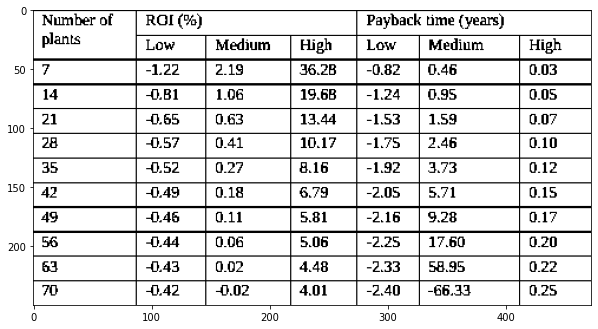

In [9]:
# Read and threshold image
img = cv2.imread(image_path, 0)  # Read image as grayscale
_, binary = cv2.threshold(img, 192, 255, cv2.THRESH_BINARY)
cv2.imwrite(os.path.join(PATH_TO_SAVE, '1.png'), img)
plt.imshow(binary, cmap='gray')
plt.show()

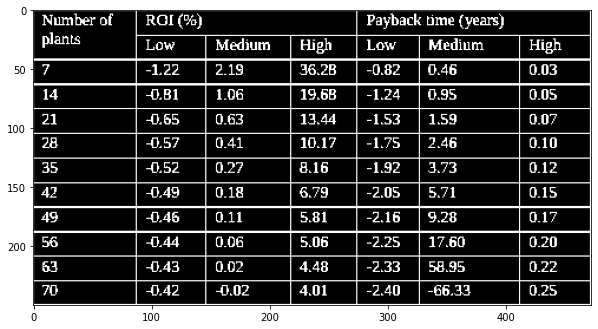

In [10]:
# Invert the image
inverted_bin_img = 255 - binary
draw_border(inverted_bin_img)
cv2.imwrite(os.path.join(PATH_TO_SAVE, '2.png'), inverted_bin_img)
plt.imshow(inverted_bin_img, cmap='gray')
plt.show()

In [11]:
# Set kernel size for erosion/dilation.
horizontal_kernel_length = img.shape[1] // max_columns // 4
vertical_kernel_length = img.shape[0] // len(rows_ann) // 4 * 3

In [12]:
if horizontal_kernel_length < 1 or vertical_kernel_length < 1:
    print('Advanced!')

In [13]:
horizontal_kernel_length, vertical_kernel_length

(16, 15)

In [14]:
img.shape

(250, 473)

In [15]:
# Horizontal kernel for detecting horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_kernel_length, 1))

# Vertical kernel for detecting vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_kernel_length))

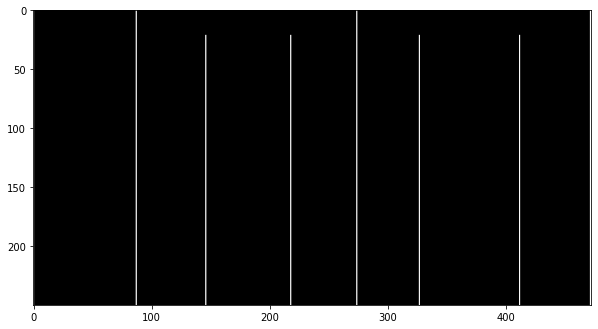

In [16]:
# Detect vertical lines
image_1 = cv2.erode(inverted_bin_img, vertical_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, vertical_kernel, iterations=3)
cv2.imwrite(os.path.join(PATH_TO_SAVE, '3a.png'), vertical_lines)
plt.imshow(vertical_lines, cmap='gray')
plt.show()

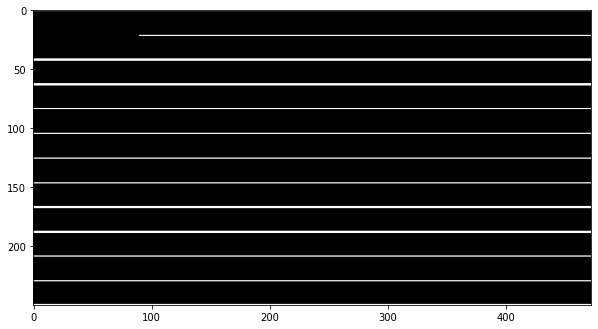

In [17]:
# Detect horizontal lines
image_2 = cv2.erode(inverted_bin_img, horizontal_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, horizontal_kernel, iterations=3)
cv2.imwrite(os.path.join(PATH_TO_SAVE, '3b.png'), horizontal_lines)
plt.imshow(horizontal_lines, cmap='gray')
plt.show()

In [18]:
rows_coordinates = []
rows_vertical_projection = [False] * len(horizontal_lines)  # False means black, True means white
for i in range(len(horizontal_lines)):
    if 255 in np.unique(horizontal_lines[i]):
        rows_vertical_projection[i] = True

In [19]:
row_idx = 0
while row_idx < len(horizontal_lines):
    quit = False
    while rows_vertical_projection[row_idx] == True:
        row_idx += 1
        if row_idx == len(horizontal_lines) - 1:
            quit = True
            break
    if quit:
        break
    row_start = row_idx
    while rows_vertical_projection[row_idx] == False:
        row_idx += 1
    row_end = row_idx - 1
    rows_coordinates.append([row_start, row_end])
    if row_idx >= len(horizontal_lines) - 1:
        break
rows_coordinates = [row_coordinates for row_coordinates in rows_coordinates if row_coordinates[1] - row_coordinates[0] > 4]

In [20]:
cols_coordinates = []
cols_horizontal_projection = [False] * len(vertical_lines[0])  # False means black, True means white
for i in range(len(vertical_lines[0])):
    if 255 in np.unique(vertical_lines[:, i]):
        cols_horizontal_projection[i] = True

In [21]:
col_idx = 0
while col_idx < len(vertical_lines[0]):
    quit = False
    while cols_horizontal_projection[col_idx] == True:
        col_idx += 1
        if col_idx == len(vertical_lines[0]) - 1:
            quit = True
            break
    if quit:
        break
    col_start = col_idx
    while cols_horizontal_projection[col_idx] == False:
        col_idx += 1
    col_end = col_idx - 1
    cols_coordinates.append([col_start, col_end])
    if col_idx >= len(vertical_lines[0]) - 1:
        break
cols_coordinates = [col_coordinates for col_coordinates in cols_coordinates if col_coordinates[1] - col_coordinates[0] > 4]

In [22]:
rows_coordinates

[[1, 20],
 [22, 40],
 [43, 61],
 [64, 82],
 [84, 103],
 [105, 124],
 [126, 145],
 [147, 165],
 [168, 186],
 [189, 207],
 [209, 228],
 [230, 248]]

In [23]:
cols_coordinates

[[1, 86],
 [88, 145],
 [147, 217],
 [219, 273],
 [275, 326],
 [328, 411],
 [413, 471]]

In [24]:
cells = []
for row_idx, row in enumerate(rows_coordinates):
    for col in cols_coordinates:
        cells.append([row[0], col[0], row[1], col[1]])
cells

[[1, 1, 20, 86],
 [1, 88, 20, 145],
 [1, 147, 20, 217],
 [1, 219, 20, 273],
 [1, 275, 20, 326],
 [1, 328, 20, 411],
 [1, 413, 20, 471],
 [22, 1, 40, 86],
 [22, 88, 40, 145],
 [22, 147, 40, 217],
 [22, 219, 40, 273],
 [22, 275, 40, 326],
 [22, 328, 40, 411],
 [22, 413, 40, 471],
 [43, 1, 61, 86],
 [43, 88, 61, 145],
 [43, 147, 61, 217],
 [43, 219, 61, 273],
 [43, 275, 61, 326],
 [43, 328, 61, 411],
 [43, 413, 61, 471],
 [64, 1, 82, 86],
 [64, 88, 82, 145],
 [64, 147, 82, 217],
 [64, 219, 82, 273],
 [64, 275, 82, 326],
 [64, 328, 82, 411],
 [64, 413, 82, 471],
 [84, 1, 103, 86],
 [84, 88, 103, 145],
 [84, 147, 103, 217],
 [84, 219, 103, 273],
 [84, 275, 103, 326],
 [84, 328, 103, 411],
 [84, 413, 103, 471],
 [105, 1, 124, 86],
 [105, 88, 124, 145],
 [105, 147, 124, 217],
 [105, 219, 124, 273],
 [105, 275, 124, 326],
 [105, 328, 124, 411],
 [105, 413, 124, 471],
 [126, 1, 145, 86],
 [126, 88, 145, 145],
 [126, 147, 145, 217],
 [126, 219, 145, 273],
 [126, 275, 145, 326],
 [126, 328, 145, 

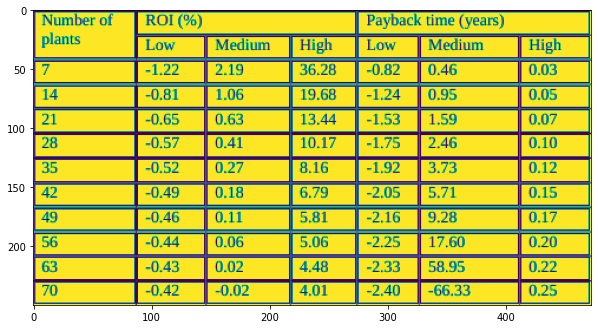

In [36]:
res_img = img.copy()
for cell in cells:
    cv2.rectangle(res_img, (cell[1], cell[0]), (cell[3], cell[2]), (0, 0, 255), 1)
cv2.imwrite(os.path.join(PATH_TO_SAVE, '4_col.png'), res_img)
plt.imshow(res_img)
plt.show()

In [26]:
current_idx = 0
while current_idx < len(cells):
    if cells[current_idx] is None:
        current_idx += 1
        continue
    else:
        current_cell = cells[current_idx]
        inner_idx = current_idx + 1
        while inner_idx < len(cells):
            cell = cells[inner_idx]
            if cell is not None:
                if current_cell[0] == cell[0] and current_cell[2] == cell[2]:
                    # These two cells are horizontally aligned
                    check_area = vertical_lines[current_cell[0]: current_cell[2] + 1, current_cell[3] + 1: cell[1]]
                    if len(np.unique(check_area)) == 1 and np.unique(check_area)[0] == 0:
                        cells[current_idx][3] = cell[3]
                        cells[inner_idx] = None
                elif current_cell[1] == cell[1] and current_cell[3] == cell[3]:
                    # These two cells are vertically aligned
                    check_area = horizontal_lines[current_cell[2] + 1: cell[0], current_cell[1] : current_cell[3] + 1]
                    if len(np.unique(check_area)) == 1 and np.unique(check_area)[0] == 0:
                        cells[current_idx][2] = cell[2]
                        cells[inner_idx] = None
            inner_idx += 1
        current_idx += 1

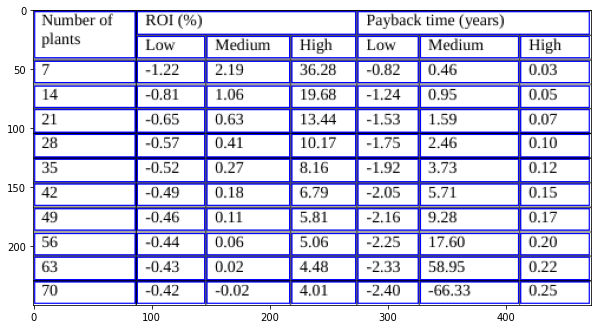

In [31]:
res_img2 = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
for cell in cells:
    if cell is not None:
        cv2.rectangle(res_img2, (cell[1], cell[0]), (cell[3], cell[2]), (0, 0, 255), 1)
cv2.imwrite(os.path.join(PATH_TO_SAVE, '5.png'), res_img2)
plt.imshow(res_img2, cmap='gray')
plt.show()

In [32]:
cells = [cell for cell in cells if cell is not None]
cells

[[1, 1, 40, 86],
 [1, 88, 20, 273],
 [1, 275, 20, 471],
 [22, 88, 40, 145],
 [22, 147, 40, 217],
 [22, 219, 40, 273],
 [22, 275, 40, 326],
 [22, 328, 40, 411],
 [22, 413, 40, 471],
 [43, 1, 61, 86],
 [43, 88, 61, 145],
 [43, 147, 61, 217],
 [43, 219, 61, 273],
 [43, 275, 61, 326],
 [43, 328, 61, 411],
 [43, 413, 61, 471],
 [64, 1, 82, 86],
 [64, 88, 82, 145],
 [64, 147, 82, 217],
 [64, 219, 82, 273],
 [64, 275, 82, 326],
 [64, 328, 82, 411],
 [64, 413, 82, 471],
 [84, 1, 103, 86],
 [84, 88, 103, 145],
 [84, 147, 103, 217],
 [84, 219, 103, 273],
 [84, 275, 103, 326],
 [84, 328, 103, 411],
 [84, 413, 103, 471],
 [105, 1, 124, 86],
 [105, 88, 124, 145],
 [105, 147, 124, 217],
 [105, 219, 124, 273],
 [105, 275, 124, 326],
 [105, 328, 124, 411],
 [105, 413, 124, 471],
 [126, 1, 145, 86],
 [126, 88, 145, 145],
 [126, 147, 145, 217],
 [126, 219, 145, 273],
 [126, 275, 145, 326],
 [126, 328, 145, 411],
 [126, 413, 145, 471],
 [147, 1, 165, 86],
 [147, 88, 165, 145],
 [147, 147, 165, 217],
 [14

In [33]:
def trim_bbox(img, bbox):
    top = bbox[0]
    left = bbox[1]
    bottom = bbox[2]
    right = bbox[3]
    if len(np.unique(img[top : bottom + 1, left : right + 1])) == 1:
        return None  # Empty cells. No need to trim. Just return None
    # Clear any undetected white border lines
    while top < bottom:
        if len(np.unique(img[top, left: right + 1])) == 1 and np.unique(img[top, left: right + 1])[0] == 255:
            top += 1
        else:
            break
    while bottom > top:
        if len(np.unique(img[bottom, left: right + 1])) == 1 and np.unique(img[bottom, left: right + 1])[0] == 255:
            bottom -= 1
        else:
            break
    while left < right:
        if len(np.unique(img[top : bottom + 1, left])) == 1 and np.unique(img[top : bottom + 1, left])[0] == 255:
            left += 1
        else:
            break
    while right > left:
        if len(np.unique(img[top : bottom + 1, right])) == 1 and np.unique(img[top : bottom + 1, right])[0] == 255:
            right -= 1
        else:
            break
    # Trim bbox
    while top < bottom:
        if len(np.unique(img[top, left: right + 1])) == 1 and np.unique(img[top, left: right + 1])[0] == 0:
            top += 1
        else:
            break
    while bottom > top:
        if len(np.unique(img[bottom, left: right + 1])) == 1 and np.unique(img[bottom, left: right + 1])[0] == 0:
            bottom -= 1
        else:
            break
    while left < right:
        if len(np.unique(img[top : bottom + 1, left])) == 1 and np.unique(img[top : bottom + 1, left])[0] == 0:
            left += 1
        else:
            break
    while right > left:
        if len(np.unique(img[top : bottom + 1, right])) == 1 and np.unique(img[top : bottom + 1, right])[0] == 0:
            right -= 1
        else:
            break
    return [top, left, bottom, right]

new_cells = []
for cell in cells:
    new_bbox = trim_bbox(inverted_bin_img, cell)
    if new_bbox is not None:
        new_cells.append(new_bbox)
# for i in range(len(cells)):
#     new_row = []
#     for j in range(len(cells[i])):
#         new_bbox = trim_bbox(inverted_bin_img, cells[i][j])
#         if new_bbox is not None:
#             new_row.append(new_bbox)
#     new_cells.append(new_row)
new_cells

[[3, 8, 31, 67],
 [3, 96, 15, 142],
 [3, 283, 15, 398],
 [25, 96, 33, 119],
 [24, 155, 33, 200],
 [24, 227, 36, 252],
 [25, 283, 33, 307],
 [24, 336, 33, 381],
 [24, 421, 36, 447],
 [46, 8, 54, 13],
 [46, 96, 54, 123],
 [46, 155, 54, 177],
 [46, 226, 54, 256],
 [46, 283, 54, 310],
 [46, 335, 54, 358],
 [46, 421, 54, 443],
 [67, 9, 75, 20],
 [67, 96, 75, 122],
 [67, 156, 75, 177],
 [67, 227, 75, 256],
 [67, 283, 75, 310],
 [67, 335, 75, 358],
 [67, 421, 75, 443],
 [88, 8, 96, 19],
 [88, 96, 96, 123],
 [88, 155, 96, 177],
 [88, 227, 96, 256],
 [88, 283, 96, 310],
 [88, 336, 96, 358],
 [88, 421, 96, 443],
 [108, 8, 116, 20],
 [108, 96, 116, 123],
 [108, 155, 116, 177],
 [108, 227, 116, 256],
 [108, 283, 116, 310],
 [108, 335, 116, 358],
 [108, 421, 116, 443],
 [129, 8, 137, 20],
 [129, 96, 137, 123],
 [129, 155, 137, 177],
 [129, 226, 137, 249],
 [129, 283, 137, 310],
 [129, 335, 137, 358],
 [129, 421, 137, 443],
 [150, 7, 158, 19],
 [150, 96, 158, 123],
 [150, 155, 158, 177],
 [150, 226,

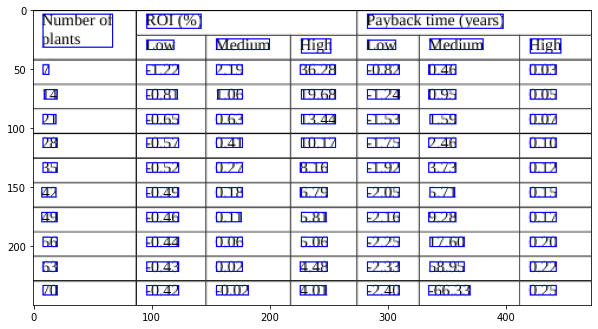

In [35]:
res_img3 = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
for cell in new_cells:
    cv2.rectangle(res_img3, (cell[1], cell[0]), (cell[3], cell[2]), (0, 0, 255), 1)
cv2.imwrite(os.path.join(PATH_TO_SAVE, '6.png'), res_img3)
plt.imshow(res_img3, cmap='gray')
plt.show()

In [ ]:
len(new_cells) == total_cells_non_empty

In [ ]:
# Check if number of rows/columns in annotation file and in detected rows/columns match
matched = True
if len(rows_ann) == len(cells):  # Check if numbers of rows are equal
    for i in range(rows_ann)
#     rows_mapped = []
#     for i in range(len(rows)):
#         rows_temp = []
#         visible_col_count = 0
#         for j in range(len(rows[i])):
#             if rows[i][j] == 'tdn':
#                 rows_temp.append({'tdn': {}})
#             elif visible_col_count < len(sorted_rows[i]):
#                 rows_temp.append({'tdy': sorted_rows[i][visible_col_count]})
#                 visible_col_count += 1
#             else:
#                 matched = False
#                 break
#         if visible_col_count != rows[i].count('tdy') or not matched:
#             matched = False
#             break
#         rows_mapped.append(rows_temp)
else:
    matched = False

In [ ]:
rows_ann